In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute

X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))

X_motion = X_footsteps_continuous_absolute
Y_motion = Y_footsteps_continuous_absolute

print(X_motion.shape)
print(Y_motion.shape)

(696, 24)
(696, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [7]:
## Entries where FL is swinging
idxs = np.where(X_motion[:, -2] == 1)[0]
X_motion_FL_swinging = X_motion[idxs]
Y_motion_FL_swinging = Y_motion[idxs]

## Predict FL foot -> x

In [8]:
X_motion_FL_swinging[10]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.22771218,  0.12842976, -0.38347515,  0.25858542,
       -0.13064995, -0.37084213, -0.24112752,  0.12249345, -0.37609339,
       -0.27204502, -0.12933511, -0.38368991,  0.12237678, -0.01544414,
       -0.05792018, -0.01403652,  1.        ,  0.        ])

In [9]:
X_motion_FL_swinging[10, 18:22]

array([ 0.12237678, -0.01544414, -0.05792018, -0.01403652])

In [10]:
Y_motion_FL_swinging.shape

(351, 4)

In [11]:
X_motion_FL_swinging[0:10, 0]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

### Linear Regression

In [16]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, 3:6], # Current motion command
               X_motion_FL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_FL_swinging[:, 6:8], # FL (x,y) position
               X_motion_FL_swinging[:, 9:11], # FR (x,y) position
               X_motion_FL_swinging[:, 12:14], # RL (x,y) position
               X_motion_FL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)
    
# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9898198733783032
RMSE:  0.011964043211243223
The lowest error is:  0.00012413571758645991
The highest error is:  0.05002356200497854
The avg. error is:  0.007951522411797566


In [17]:
model_fl_relative_support_x.coef_

array([[-1.75969490e-03,  0.00000000e+00,  5.55111512e-17,
         1.50278129e-01,  9.62771529e-17,  2.22044605e-16,
         4.76615260e-01,  2.04157388e-01, -5.34510567e-01,
        -1.91558958e-01, -7.15783018e-01,  9.53963897e-01,
        -3.77230896e-01, -4.66959199e-01, -6.30361027e-01,
        -8.54771046e-02]])

In [18]:
model_fl_relative_support_x.intercept_

array([0.23294234])

Text(0, 0.5, 'Predictions')

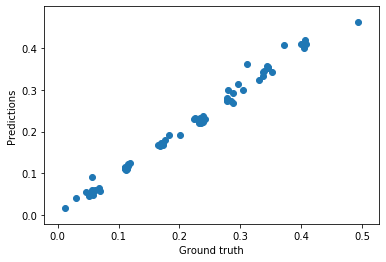

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict FL foot -> y

In [22]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, 3:6], # Current motion command
               X_motion_FL_swinging[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_FL_swinging[:, 6:8], # FL (x,y) position
               X_motion_FL_swinging[:, 9:11], # FR (x,y) position
               X_motion_FL_swinging[:, 12:14], # RL (x,y) position
               X_motion_FL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.4921267935773387
RMSE:  0.004086270498138872
The lowest error is:  7.649802293621666e-05
The highest error is:  0.014340398964080348
The avg. error is:  0.0030882389907340856


In [23]:
model_fl_relative_support_y.coef_

array([[-2.61834663e-03, -4.28476699e-16,  7.80625564e-17,
        -6.22694434e-04, -3.33066907e-16,  1.94289029e-16,
         9.93162451e-02,  1.21779523e-01,  4.21585899e-01,
        -1.25129406e+00,  1.08812574e-01,  2.67777169e-01,
        -5.44496711e-01,  3.20590753e-01, -4.17581220e-01,
        -7.72984704e-02]])

In [24]:
model_fl_relative_support_y.intercept_

array([-0.23427388])

Text(0, 0.5, 'Predictions')

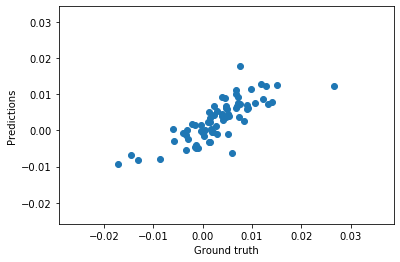

In [25]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [22]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')